# Анализ системы метрик приложения

В ходе проекта будут использованы данные приложения Procrastinate Pro+, которое предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Основная цель - определение причины стагнации выручки.

Ключевые задачи:

- провести анализ юнит-экономики продукта в динамике за первые 28 дней ;
- определение причин стагнации выручки ;
- определение источников привлечения приносящих прибыль ;
- Формирование выводов и рекомендаций.


### Описание данных

Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


---

###  Загрузка данных и знакомство

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Загружаем датасеты с парсигом дат

visits = pd.read_csv(visits_path, parse_dates=['session_start','session_end'])
orders = pd.read_csv(orders_path,parse_dates=['event_dt'])
costs = pd.read_csv(costs_path,parse_dates=['dt'])

Для знакомства с данными используем функцию аналогичную методу `info()`, но с небольшими доработками для экономии времени.

In [82]:
def cool_info (df):
    """
    1. Определяет типы данных полей и выводит информацию о них

    2. Определяет общее кол-во строк датасета

    3. Выводит информацию о полях аналогично методу indo() с
    дополнительным вычслением доли пропусков и сортировкой по
    убыванию этой доли

    """
# Параметры:
# df: датафрейм для анализа

    # Создаём датафрейм аналогичный методу info c сортировкой по доле пропусков
    info = pd.DataFrame({
        'Поле': df.columns,
        'Число не пустых значений': df.count().values,
        'Тип данных': df.dtypes.values,
        'Доля пропусков': (df.isnull().sum().values / len(df)).round(4)
    }).sort_values('Доля пропусков', ascending=False)

    # Считаем типы данных
    dtype_counts = df.dtypes.value_counts()

    # Форматируем вывод
    report = f"""
РАСПРЕДЕЛЕНИЕ ТИПОВ ДАННЫХ:
{dtype_counts.to_string()}
\nВсего строк:
{df.shape[0]}

    """

    print(report)
    display(info.round(2))

    return info

Выводим информацию о полях и первые строки датасетов.

In [83]:
cool_info(visits)
print()
display(visits.head(5))


РАСПРЕДЕЛЕНИЕ ТИПОВ ДАННЫХ:
object            3
datetime64[ns]    2
int64             1

Всего строк:
161865

    


,Поле,Число не пустых значений,Тип данных,Доля пропусков
0,user_id,161865,int64,0.0
1,region,161865,object,0.0
2,device,161865,object,0.0
3,channel,161865,object,0.0
4,session_start,161865,datetime64[ns],0.0
5,session_end,161865,datetime64[ns],0.0


,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


In [84]:
cool_info(orders)
print()
display(orders.head(5))


РАСПРЕДЕЛЕНИЕ ТИПОВ ДАННЫХ:
int64             1
datetime64[ns]    1
float64           1

Всего строк:
33893

    


,Поле,Число не пустых значений,Тип данных,Доля пропусков
0,user_id,33893,int64,0.0
1,event_dt,33893,datetime64[ns],0.0
2,revenue,33893,float64,0.0


,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


In [85]:
cool_info(costs)
print()
display(costs.head(5))


РАСПРЕДЕЛЕНИЕ ТИПОВ ДАННЫХ:
datetime64[ns]    1
object            1
float64           1

Всего строк:
976

    


,Поле,Число не пустых значений,Тип данных,Доля пропусков
0,dt,976,datetime64[ns],0.0
1,channel,976,object,0.0
2,costs,976,float64,0.0


,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


* Во всех датасетах типы данных корректны, содержимое полей соотвествует их названию.


* Пропуски отсутствуют.

### Проверка на дубликаты и аномалии

Проверим датасеты на явные дубликаты.

In [86]:
# Функция для проверки на явные бубликаты

def check_duplicates(df,df_name):
    """
    Проверяет датасет на явные дубликаты
    """
    # Параметры:
    # df: датафрейм для анализа
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"\nЧисло явных дубликатов в датасете {df_name} : {duplicates}")
    else :
        print(f"\nЯвных дубликатов в датасете {df_name} не найдено")

In [87]:
# Проверяем датасеты
check_duplicates(visits,'visits')
check_duplicates(orders,'orders')
check_duplicates(costs,'costs')


Явных дубликатов в датасете visits не найдено

Явных дубликатов в датасете orders не найдено

Явных дубликатов в датасете costs не найдено


Проверим данные с датой на ошибки.

In [88]:
def check_dates(df, check_columns):
    """
    Выводит информацию о данных полей
    """
    # Параметры:
    # df: датафрейм для анализа
    # check_columns: поля для вывода информации
    for column in check_columns:
        print(f"\n{'='*60}")
        print(f"Проверка поля {column}")
        print(f"\nМинимальное значение:{df[column].min()}")
        print(f"Максимальное значение поля:{df[column].max()}")
        print(f"Количество уникальных значений: {df[column].nunique()}")

In [89]:
print(f"\nПроверка полей с датами на аномалии")
print(f"Датасет visits")
check_dates(visits, visits_dt_list)
print(f"\nДатасет orders")
check_dates(orders, orders_dt_list)
print(f"Датасет costs")
check_dates(costs, costs_dt_list)


Проверка полей с датами на аномалии
Датасет visits

Проверка поля session_start

Минимальное значение:2024-04-01 00:07:00
Максимальное значение поля:2024-11-30 23:59:00
Количество уникальных значений: 128645

Проверка поля session_end

Минимальное значение:2024-04-01 00:22:00
Максимальное значение поля:2024-12-01 01:40:00
Количество уникальных значений: 128807

Датасет orders

Проверка поля event_dt

Минимальное значение:2024-04-01 00:53:40
Максимальное значение поля:2024-11-30 23:55:50
Количество уникальных значений: 33863
Датасет costs

Проверка поля dt

Минимальное значение:2024-04-01 00:00:00
Максимальное значение поля:2024-11-30 00:00:00
Количество уникальных значений: 244


Во всех полях с датой данные в пределах нормы, явных аномалий не обнаружено.

Проверим данные числовых полей.

In [90]:
def check_numeric (df, check_columns):
    """
    1. Выводит описательные статистики числового поля

    2. Строит гистограмму распределения значений и
    диаграмму размаха для оценки на выбросы
    """
    # Параметры:
    # df: датафрейм для анализа
    # check_columns: поля для вывода информации
    for column in check_columns:
        # Вывод описательных статистик
        print(f"\nИнформация о данных поля {column}")
        display(df[column].describe().round(2))
        # Построение графиков
        plt.figure(figsize=(12, 6))
        # Гистограмма
        plt.subplot(1, 2, 1)
        sns.histplot(
            data=df,
            x=df[column],
            bins=25
        )
        plt.title(f"Распределения значений {column}")
        plt.xlabel('Значение')
        plt.ylabel('Кол-во')
        # boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(
            data=df,
            x=df[column]
        )
        # Оформление
        plt.title(f"Диаграмма размаха поля {column}")

        plt.tight_layout()
        plt.show()

Проверка полей с числовыми данными

Датасет orders

Информация о данных поля revenue


,revenue
count,33893.00
mean,3.44
std,2.19
min,2.99
25%,2.99
50%,2.99
75%,2.99
max,29.99


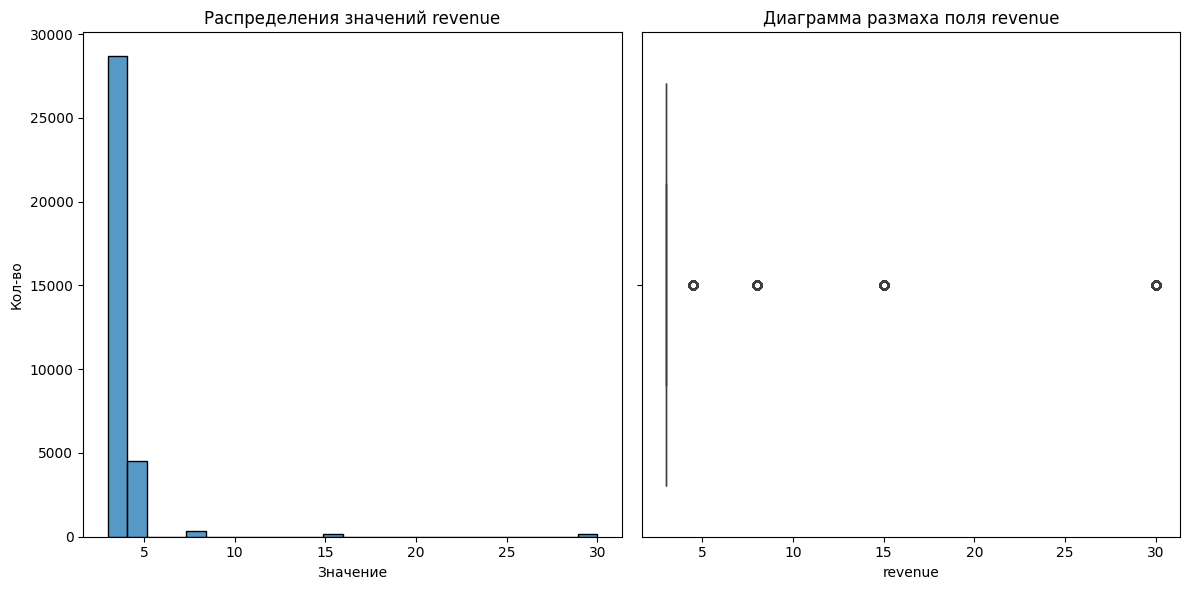

In [91]:
print(f"Проверка полей с числовыми данными")

print(f"\nДатасет orders")
orders_numeric_list = ['revenue']
check_numeric(orders, orders_numeric_list)


* **75%** покупок до 2.99 $


* Максимальное значение поля **29.99**$ значительно превышает остальные данные - похоже на выброс.

Проверим значения поля *revenue*.

In [92]:
orders.sort_values('revenue',ascending=False)['revenue'].value_counts()

,count
revenue,
2.99,28674
4.49,4528
7.99,347
29.99,173
14.99,171


Все в порядке, это просто стоимость самого дорогого тарифа.


Датасет costs

Информация о данных поля costs


,costs
count,976.00
mean,81.69
std,70.24
min,9.05
25%,19.55
50%,54.28
75%,134.50
max,316.92


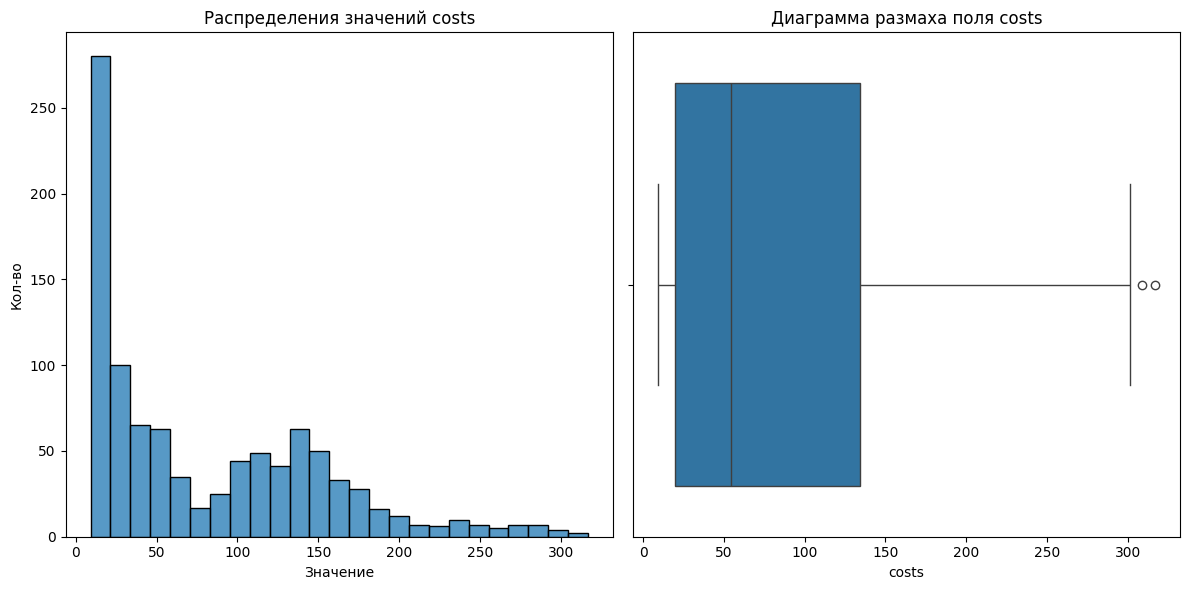

In [93]:
print(f"\nДатасет costs")
costs_numeric_list = ['costs']
check_numeric(costs, costs_numeric_list)

* Максимальное значение почти в 3 раза выше среднего.


* С учетом контекста данных поля (стоимость затрат на рекламу) по предварительной оценке аномалий нет.


## Подготовка данных к когортному анализу

Подготовим данные к когортному анализу с учётом того, что вы будете изучать окупаемость привлечения пользователей за первые 28 дней.

### Создание вспомогательного датасета с информацией о стоимости привлечения


Назовем новы датасет `profiles`, соберем в нем следующие данные :

* *user_id* - уникальный идентификатор пользователя

* *first_dt* - Дату первого посещения

* *first_channel* - Канал привлечения

* *CAC* - Стоимость - привлечения

In [94]:
# cоздаем вспомогательный датасет
profiles = (visits.sort_values(by='session_start')
.groupby('user_id')
.agg(
    first_dt = ('session_start', 'min'),
    first_channel = ('channel', 'first')
).reset_index().sort_values('first_dt')
)

profiles['first_dt'] = profiles['first_dt'].dt.floor('D')


In [95]:
# Создаем датасет для рассчета CAC
# Датасет со стоимостью привлечения по каналам и дням
acquisition_costs = costs.groupby(['dt','channel'])['costs'].sum().reset_index().sort_values('dt')
# Датасет с числом новых пользователей по дням
new_users_count = profiles.groupby('first_dt')['user_id'].nunique().reset_index().sort_values('first_dt')
# Объединение данных
cac_data = acquisition_costs.merge(
    new_users_count,
    left_on='dt',
    right_on='first_dt',
    how='left'
)
# Расчет поля CAC
cac_data['CAC'] = (cac_data['costs'] / cac_data['user_id']).round(2)

# Объединение данных в итоговый датасет
profiles = profiles.merge(
    cac_data[['CAC','first_dt', 'channel']],
    left_on=['first_dt','first_channel'],
    right_on=['first_dt','channel'],
    how='left'
)

profiles = profiles.drop('channel', axis=1)

In [96]:
# Выводим информацию о датасете

cool_info(profiles)
print()
display(profiles.head(3))

print(f"\nЧисло явных дубликатов : {profiles.duplicated().sum()}")
print(f"\nЧисло дубликатов по полю user_id : {profiles.duplicated(subset='user_id').sum()}")


РАСПРЕДЕЛЕНИЕ ТИПОВ ДАННЫХ:
int64             1
datetime64[ns]    1
object            1
float64           1

Всего строк:
74856

    


,Поле,Число не пустых значений,Тип данных,Доля пропусков
0,user_id,74856,int64,0.0
1,first_dt,74856,datetime64[ns],0.0
2,first_channel,74856,object,0.0
3,CAC,74856,float64,0.0


,user_id,first_dt,first_channel,CAC
0,767410614400,2024-04-01,MediaTornado,0.06
1,641772204272,2024-04-01,MediaTornado,0.06
2,934895210751,2024-04-01,RocketSuperAds,0.17



Число явных дубликатов : 0

Число дубликатов по полю user_id : 0


Датасет успешно сформирован, пропусков и дубликатов нет. Теперь добавим к таблицам *orders* *visits* необходимые для рассчетов поля :

* *first_dt* - Дата первого посещения

* *first_channel* - Канал привлечения

* *n_days* - дневной лайфтайм

* *cohort_month* - месяц когорты

In [97]:
merge_data = profiles[['user_id','first_dt','first_channel']]

orders = orders.merge(
    merge_data,
    on='user_id'
)

visits = visits.merge(
    merge_data,
    on='user_id'
)

In [98]:
# Рассчет лайфтайма и определения месячных когорт
orders['n_days'] = (orders['event_dt'].dt.floor('D') - orders['first_dt']).dt.days
orders['cohort_month'] = orders['first_dt'].dt.to_period('M')
visits['n_days'] = (visits['session_start'].dt.floor('D') - visits['first_dt']).dt.days
visits['cohort_month'] = visits['first_dt'].dt.to_period('M')

visits['session_date'] = visits['session_start'].dt.floor('D')
orders['session_date'] = orders['event_dt'].dt.floor('D')


In [99]:
profiles

,user_id,first_dt,first_channel,CAC
0,767410614400,2024-04-01,MediaTornado,0.06
1,641772204272,2024-04-01,MediaTornado,0.06
2,934895210751,2024-04-01,RocketSuperAds,0.17
3,226472994774,2024-04-01,FaceBoom,0.35
4,686701513307,2024-04-01,MediaTornado,0.06
...,...,...,...,...
74851,830433450716,2024-11-30,RocketSuperAds,0.07
74852,208650899766,2024-11-30,RocketSuperAds,0.07
74853,625972196056,2024-11-30,TipTop,0.76
74854,19037749270,2024-11-30,TipTop,0.76


In [100]:
profiles.groupby('cohort_month')['user_id'].nunique()

KeyError: 'cohort_month'

---

## Анализ месячной динамики основных метрик продукта

Начнем с изучения динамики активности пользователей и их вовлечённости в продукт. Рассчитаем по всем данным значения DAU, MAU и Stickiness и визуализируем их. Активными будем считать всех пользователей, которые взаимодействовали с приложением.

### Анализ динамики активности ользователей

In [ ]:
visits['session_month'] = visits['session_date'].dt.to_period('M')
# Создаем вспомогательный датасет для рассчета DAU
group_cols = ['session_date','session_month']

dau_data = visits.groupby(group_cols).agg(
    DAU = ('user_id','nunique')
).reset_index()
# Создаем вспомогательный датасет для рассчета MAU
group_cols = ['session_month']

mau_data = visits.groupby(group_cols).agg(
    MAU = ('user_id','nunique')
).reset_index()
# Объединяем данные, рассчитываем Stickiness
stickyness_data = dau_data.merge(
    mau_data,
    on='session_month'
)
stickyness_data['stickyness'] = (stickyness_data['DAU'] / stickyness_data['MAU'])*100
# Выводим первые строки
stickyness_data.head(5)

Теперь построим графики для каждой метрики.

In [ ]:
# Предобработка

# Скользящее среднее для DAU
stickyness_data['DAU_MA'] = stickyness_data['DAU'].rolling(7, min_periods=1).mean()
# Преобразование в timestamp для отрисовки seaborn
dates_day = stickyness_data['session_date']
dates_month = stickyness_data['session_month'].dt.to_timestamp()
# Отметка начала нового контента
launch_date = pd.Timestamp('2024-06-01')

# Линейная регрессия для stickyness
x = np.arange(len(stickyness_data))
slope, intercept = np.polyfit(x, stickyness_data['stickyness'], 1)
stickyness_data['trend'] = intercept + slope * x

# Визуализация

# DAU
plt.figure(figsize=(14,10))
sns.lineplot(x=dates_day, y=stickyness_data['DAU'], alpha=0.7,label='DAU')
sns.lineplot(x=dates_day, y=stickyness_data['DAU_MA'], linestyle='--',label='Скользящее среднее (7 дней)')
plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента')
plt.title('DAU по дням и скользящее среднее')
plt.xlabel('Месяц')
plt.ylabel('DAU')
plt.grid(alpha=0.7)
plt.legend()
# MAU
plt.figure(figsize=(14,10))
sns.lineplot(x=dates_month, y=stickyness_data['MAU'])
plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента')
plt.title('MAU')
plt.xlabel('Месяц')
plt.ylabel('MAU')
plt.grid(alpha=0.7)
plt.legend()
# Stickyness + тренд
plt.figure(figsize=(14,10))
sns.lineplot(x=dates_day, y=stickyness_data['stickyness'], linewidth=2,label='stickyness')
sns.lineplot(x=dates_day, y=stickyness_data['trend'], linestyle='--',label='Линия тренда')
plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента')
plt.title(f'Stickyness (тренд: {slope:.4f}% в день)')
plt.xlabel('Месяц')
plt.ylabel('Stickyness')
plt.grid(alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

* Метрики DAU и MAU показывают стабильный рост. Это говорит о том что продукт успешно наращивает активную аудиторию.


* Резкий рост Stickyness в начале лета указывает на заинтересованность пользователей новым контентом, но откат до прежних значений в начале июля говорит о преблемах с удержанием.  При этом общий тренд метрики нположительный, что коррелирует с ростом DAU и MAU.


* Положительный тренд всех метрик пользовательской активности показывает что в целом пользователи заинтересованы продуктом.

---

### Анализ финансовых метрик

Проведем анализ финансовых метрик **CAC**, **LTV** и  **ROI** по всем данным.

Для начала визуализируем стоимость привлечения пользователей по месяцам привлечения.

In [ ]:
# Новое поле с месяцем привлечения
profiles['cohort_month'] = profiles['first_dt'].dt.to_period('M')
# Поля группировки
group_cols = ['cohort_month']
# Группировка данные и рассчитывем метрики
cac_data = profiles.groupby(group_cols).agg(
    users_count = ('user_id', 'nunique'),
    CAC = ('CAC', 'mean')
).reset_index()

cac_data.head(5)

In [ ]:
# Форматирование для seaborn
x_values = cac_data['cohort_month'].dt.to_timestamp()
# Отметка начала нового контента
launch_date = pd.Timestamp('2024-06-01')

# Визуализация
fig, ax1 = plt.subplots(figsize=(12, 6))

# CAC на левой оси (основная)
color = 'blue'
ax1.set_xlabel('Месяц привлечения')
ax1.set_ylabel('CAC', color=color, fontsize=12)
line1 = ax1.plot(x_values, cac_data['CAC'], color=color, linewidth=2, label='CAC')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)

# Создаем вторую ось для количества пользователей
ax2 = ax1.twinx()
color = 'green'
ax2.set_ylabel('Количество новых пользователей', color=color, fontsize=12)
line2 = ax2.plot(x_values, cac_data['users_count'], color=color, linewidth=2, linestyle='--', label='Новые пользователи')
ax2.tick_params(axis='y', labelcolor=color)

# Вертикальная линия запуска контента
ax1.axvline(x=launch_date, color='red', alpha=0.5, label='Введение спортивного контента')

# Объединяем легенды
lines = line1 + line2
labels = [l.get_label() for l in lines] + ['Введение спортивного контента']
ax1.legend(lines + [plt.Line2D([0], [0], color='red', linewidth=2)], labels, loc='upper left')

plt.title('CAC и количество новых пользователей по месяцам', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* CAC стабильно растет мая.

* Средняя выручка от новых пользователей показывает значительный рост в июне, а затем начинает снижаться достагая минимума в ноябре.

* Число новых пользователей резко снижается в мае, но затем начинает расти в начале лета.

В мае САС резко растет, что коррелирует с падением числа новых пользователей. Далее метрика стабильно растет несмотря на рост числа новых пользователей, что указывает на значительное увеличение затрат на привлечение.

---

Теперь рассмотрим основные финансовые метрики - **LTV** и **ROI** с учётом покупок, совершённых за 28 дней с момента привлечения.

In [ ]:
# Создание датасета с данными за первые 28 дней после привлечения
orders['cohort_month'] = orders['first_dt'].dt.to_period('M')
n_days_limit = 28

# Группировка данных
# Выручка по месяцам когорт за 28 дней
revenue_mothly = orders[orders['n_days']<=n_days_limit].groupby('cohort_month').agg(
    revenue = ('revenue', 'sum')
).reset_index()
# Число пользоватей по когортам
users_mothly = visits[visits['n_days']<=n_days_limit].groupby('cohort_month').agg(
    users_count = ('user_id', 'nunique')
).reset_index()
# Объединение числа пользователй и выручки
ltv_data = revenue_mothly.merge(
    users_mothly,
    on='cohort_month'
)
# Добавление CAC
ltv_data = ltv_data.merge(
    cac_data[['cohort_month','CAC']],
    on='cohort_month'
)
# рассчет LTV, ROI
ltv_data['LTV'] = ltv_data['revenue'] / ltv_data['users_count']
ltv_data['ROI'] = ((ltv_data['LTV'] - ltv_data['CAC']) / ltv_data['CAC']) * 100

ltv_data.round(2)

In [ ]:
# Форматирование для seaborn
x_values = ltv_data['cohort_month'].dt.to_timestamp()
# Отметка введения нового контента
launch_date = pd.Timestamp('2024-06-01')

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['LTV', 'CAC', 'ROI','users_count']
titles = ['LTV', 'CAC', 'ROI %', 'Число новых пользователей']


for k,(metric,title) in enumerate(zip(metrics,titles)):
    row,col = k//2, k%2
    ax= axes[row, col]
    # Лайнплот
    sns.lineplot(data=ltv_data,x=x_values, y=metric,ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')

    ax.axvline(x=launch_date, color='red',label='Введение спротивного контента', alpha=0.6)
    ax.grid(alpha=0.3)
    ax.legend()
# Оформление
plt.suptitle('Ключевые метрики за 28 дней с момента привлечения', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

* LTV резко возрастает в начале лета, что коррелирует с введением нового контента и стратегии маркетинга. В ноябре резко откатывается до значений начала июня.

* Число новых пользователей с начала июня растет.

* ROI падает с мая.


#### Промежуточный итог :

* ROI стабильно падает достигая минимума в ноябре. Общий тренд показывает что рост выручки не перекрывает рост затрат на привлечение.

* Стабильный рост DAU, MAU и stickyness указывает на заинтересованность пользователей продуктом.

* Число новых пользователей резко упало в мае до минимальных значений, после чего начало расти достигнув максимума в ноябре.

Опираясь на данные можно сделать вывод что у продукта нет проблем с привлечением новых пользователей, при этом они продолжают стабильно возвращаться.Существенное и стабильное снижение ROI показывает что **рост LTV не перекрывает рост расходов на привлечение.**

---

## Анализ метрик в разрезе источника привлечения

Теперь необходимо разобраться, какие источники привлечения перспективны, а какие за 28 дней не окупились.


### Анализ источников привлечения по кол-ву пользователей

Для начала определим сколько всего пользователей пришло по каналам за весь период.

In [ ]:
# Поля для группировки
group_cols = ['first_channel']
# Агрегация
channel_counts = visits.groupby(group_cols).agg(
    user_count = ('user_id', 'nunique'),
    user_share = ('user_id', lambda x: (x.nunique() / visits['user_id'].nunique())*100)
).reset_index().sort_values('user_count',ascending=False).round(2)

# Рассчет общих затрат
channel_costs_data = costs.groupby('channel')['costs'].sum().reset_index().round(2)

channel_counts = channel_counts.merge(channel_costs_data, left_on='first_channel',right_on='channel').drop('channel',axis=1)
# рассчет средней стоимости
channel_counts['avg_cost'] = (channel_counts['costs'] / channel_counts['user_count'])

channel_counts

In [ ]:
# Визуализация сравнения
# Параметры
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = {'FaceBoom':'#023e8a','TipTop':'#ee9b00','RocketSuperAds':'#ae2012','MediaTornado':'#0a9396'}
# Метрики
metrics = ['user_count', 'user_share', 'costs', 'avg_cost']
# Заголовки
titles = ['Число пользователей', 'Доля пользователей %', 'Общие затраты на канал $', 'Средняя стоимость пользователя $']
# Датасет
plot_data = channel_counts.reset_index()
# Создание сетки графиков
for k, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = k // 2, k % 2
    ax = axes[row, col]

    # Строим барплот
    sns.barplot(data=plot_data.sort_values(metric,ascending=False), x='first_channel', y=metric, ax=ax,palette=colors)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')

    # Добавляем подписи на бары
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()

            # Форматируем текст в зависимости от метрики
            if metric == 'user_share':
                text = f'{height:.1f}%'
            elif metric == 'avg_cost':
                text = f'{height:,.2f}'
            else:  # количество рейсов
                text = f'{height:,.0f}'.replace(',', ' ')

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (height * 0.005),
                text,
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold'
            )

    # Форматируем ось Y
    # Целые числа
    if metric != 'user_share':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'.replace(',', ' ')))
    # Проценты
    else:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}%'.replace(',', ' ')))
# Основной заголовок
plt.suptitle('Сравнение каналов привлечения', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

* Больше всего пользователей пришло через **FaceBoom**, но при этом на этот канал было затрачено больше всего средств.


* **TipTop** при общих затратах схожих с **FaceBoom** привлек на 13 п.п. меньше пользователей.


* **RocketSuperAds** и **MediaTornado**  суммарно привели вдвое больше пользователей чем **TipTop**, при этом общие затраты почти в три раза меньше.


* Самый неэффективный по стоимости привлечения пользователя канал - **TipTop**, самые эффективные **RocketSuperAds** и **MediaTornado**.

### Анализ DAU, MAU и Stickyness по каналам привлечения

Для начала рассмотрим общую динамику привлечения новых пользователей по каналам.

In [ ]:
# Поля группировки
group_cols = ['first_channel','first_dt']
# Группировка
channel_days = visits.groupby(group_cols).agg(
    user_count = ('user_id', 'nunique')
).reset_index().sort_values(['first_channel','first_dt'],ascending=False)

channel_days

In [ ]:
# Подготовка данных
channels = ['FaceBoom','TipTop','RocketSuperAds','MediaTornado']
n_channels = len(channels)
n_cols = 2
n_rows = (n_channels + 1) // n_cols
launch_date = pd.Timestamp('2024-06-01')


# Создание сетки графиков
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, channel in enumerate(channels):
    ax = axes[i]
    channel_data = channel_days[channel_days['first_channel'] == channel].sort_values('first_dt')

    # Лайнплот
    sns.lineplot(data=channel_data, x='first_dt', y='user_count',
                 ax=ax, label='Число пользователей')

    # Линейная регрессия
    if len(channel_data) > 1:
        x_numeric = (channel_data['first_dt'] - channel_data['first_dt'].min()).dt.days
        slope, intercept = np.polyfit(x_numeric, channel_data['user_count'], 1)
        trend_line = intercept + slope * x_numeric

        # Линия тренда

        # Цвет линии по значению наклона
        if slope > 0:
            color='green'
        else:
            color='red'
        ax.plot(channel_data['first_dt'], trend_line,
                label=f'Тренд (наклон {slope.round(2)})',
                linestyle='--', color=color, linewidth=2)
    # Оформление графиков
    ax.set_title(f'{channel}', fontweight='bold')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество пользователей')
    ax.axvline(x=launch_date, color='red',label='Введение спротивного контента', alpha=0.3)
    ax.grid(alpha=0.3)
    ax.legend()
# Основной заголовок
plt.suptitle('Количество новых пользователей по каналам с линейными трендами',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

* Для **FaceBoom** и **TipTop** линия тренда показывает медленный рост с начала июня.


* По **RocketSuperAds** и **MediaTornado** резкое падение в начале лета, затем стабилизация.Линия тренда указывает на незначительное снижение.

Теперь рассмотрим поведение пользовательских метрик *DAU*, *MAU*, *stickyness* по каналам привлечения.

In [ ]:
# Поля для группировки DAU
group_cols = ['channel','session_date','session_month']
# Рассчет DAU
dau_channels = visits.groupby(group_cols).agg(
    DAU = ('user_id', 'nunique')
).reset_index().sort_values(['channel','session_date'],ascending=False)
# Поля для группировки MAU
group_cols = ['channel','session_month']
# Рассчет MAU
mau_channels = visits.groupby(group_cols).agg(
    MAU = ('user_id', 'nunique')
).reset_index().sort_values(['channel','session_month'],ascending=False)
# Рассчет stickyness по дням
stickyness_channels = dau_channels.merge(
    mau_channels,
    on=['session_month','channel']
)
stickyness_channels['stickyness'] =(stickyness_channels['DAU'] / stickyness_channels['MAU'])
stickyness_channels

In [ ]:
# Подготовка данных
channels = ['FaceBoom','TipTop','RocketSuperAds','MediaTornado']
n_channels = len(channels)
n_cols = 2
n_rows = (n_channels + 1) // n_cols
launch_date = pd.Timestamp('2024-06-01')
x_values = stickyness_channels['session_date']

# Создание сетки графиков
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, channel in enumerate(channels):
    ax = axes[i]
    channel_data = stickyness_channels[stickyness_channels['channel'] == channel].sort_values('session_date')
    channel_data['DAU_MA'] = channel_data['DAU'].rolling(7, min_periods=1).mean()
    # Лайнплот
    sns.lineplot(data=channel_data, x=x_values, y='DAU',
                 ax=ax, label='Число пользователей', alpha=0.6)
     # Скользящее среднее
    sns.lineplot(data=channel_data, x=x_values, y='DAU_MA',
                 ax=ax, label='Скользящее среднее (7 дней)')

    # Оформление графиков
    ax.set_title(f'{channel}', fontweight='bold')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество пользователей')
    ax.axvline(x=launch_date, color='red',label='Введение спротивного контента', alpha=0.3)
    ax.grid(alpha=0.3)
    ax.legend()
# Основной заголовок
plt.suptitle('DAU пользователей по каналам',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

* Для **FaceBoom**,**RocketSuperAds** и **TipTop** *DAU* стабильно растет с начала июня, для **TipTop** тренд более гладкий.


* По **MediaTornado** резкое падение *DAU* в начале лета, затем стабилизация.

In [ ]:
dates_month = stickyness_channels['session_month'].dt.to_timestamp()
# Отметка начала нового контента
launch_date = pd.Timestamp('2024-06-01')
plt.figure(figsize=(14,10))

for channel in stickyness_channels['channel'].unique():
    plot_data = stickyness_channels[stickyness_channels['channel']==channel]
    sns.lineplot(x=dates_month, y=plot_data['MAU'], alpha=0.7,label=channel)

plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента', linestyle='--')
plt.title('MAU')
plt.xlabel('Месяц')
plt.ylabel('MAU')
plt.grid(alpha=0.7)
plt.legend()

*MAU* всех каналов кроме **MediaTornado**  стабильно растет с начала июня. Для **FaceBoom** и **TipTop** рост намного быстрее,  показатель **RocketSuperAds** растет намного медленнее.

**MediaTornado** показывавает максимум в мае и не превышает 2500 пользователей в месяц за весь период.


In [ ]:
# Подготовка данных
channels = ['FaceBoom','TipTop','RocketSuperAds','MediaTornado']
metric = 'stickyness'
n_channels = len(channels)
n_cols = 2
n_rows = (n_channels + 1) // n_cols
launch_date = pd.Timestamp('2024-06-01')
x_values = stickyness_channels['session_date']
ax_fmt = plt.FuncFormatter(lambda y, _: f'{y:,.1%}'.replace(',', ' '))
# Создание сетки графиков
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, channel in enumerate(channels):
    ax = axes[i]
    channel_data = stickyness_channels[stickyness_channels['channel'] == channel].sort_values('session_date')

    # Лайнплот
    sns.lineplot(data=channel_data, x=x_values, y=metric,
                 ax=ax, label=f"{metric} %")

    # Линейная регрессия
    if len(channel_data) > 1:
        x_numeric = np.arange(len(channel_data))
        slope, intercept = np.polyfit(x_numeric, channel_data[metric], 1)
        trend_line = intercept + slope * x_numeric

        # Линия тренда

        # Цвет линии по значению наклона
        if slope > 0:
            color='green'
        else:
            color='red'
        ax.plot(channel_data['session_date'], trend_line,
                label=f'Тренд (наклон {slope.round(4)})',
                linestyle='--', color=color, linewidth=2)
    # Оформление графиков
    ax.set_title(f'{channel}', fontweight='bold')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество пользователей')
    ax.yaxis.set_major_formatter(ax_fmt)
    ax.axvline(x=launch_date, color='red',label='Введение спротивного контента', alpha=0.3)
    ax.grid(alpha=0.3)
    ax.legend()
# Основной заголовок
plt.suptitle('Stickyness по каналам с линейными трендами',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

Показатель *stickyness* для всех каналов остается стабильным, несмотря на высокую волатильность. Небольшой рост в пределах 1-2 п.п. наблюдается у **TripTop** в начале июня.

Исходя из показателей метрик по каналам можно сделать вывод, что TipTop является наверно самым активным каналом, при этом пользователи показывают хороший интерес в продукте. Для FaceBoom наоборот, в месяц приходит много пользователей, но всё это, скорее всего, единичное взаимодействие с продуктом.

---

### Анализ Retention Rate, CR в покукпку, LTV, CAC, ROI по каналам привлечения

Выделим недельные когорты пользователей и рассчитаем по ним RR c 14 по 28 день с момента привлечения чтобы определить успевают ли пользователи выйти за границу окупаемости в 28-дневный период.

Отдельно рассчитаем конверсию в покупку, LTV, ROI и CAC на 28-й день по источникам привлечения по недельным когортам.

In [ ]:
# Расчет данных RR

# Фильтрация событий в период 28 дней
visits['cohort_week'] = visits['first_dt'].dt.to_period('W')
n_days_limit = 28

retention_events = visits[visits['n_days'].between(14,28)]
# Число вернувшихся пользователей
group_cols = ['cohort_week','first_channel']

retention_data = retention_events.groupby(group_cols).agg(
    retained_users = ('user_id', 'nunique')
).reset_index()
# Размер когорт
cohort_sizes = visits.groupby(group_cols).agg(
    cohort_size = ('user_id', 'nunique')
).reset_index()
# Объединение
retention_data = retention_data.merge(
    cohort_sizes,
    on=group_cols
)
# Рассчет RR
retention_data['RR'] =( retention_data['retained_users'] / retention_data['cohort_size']) * 100
# Дата начала недели
retention_data['week_date'] = retention_data['cohort_week'].dt.start_time

retention_data.head()

In [ ]:
# Виизуализация Retention Rate
launch_date = pd.Timestamp('2024-06-01')
metric = 'RR'
plt.figure(figsize=(12,6))

for channel in retention_data['first_channel'].unique():
    channel_data = retention_data[retention_data['first_channel'] == channel]
    plt.plot(channel_data['week_date'], channel_data[metric],
                   label=channel)
plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента', linestyle='--')
plt.title(f"Динамика {metric} за период {n_days_limit} с мосента привлечения")
plt.ylabel('RR, %')
plt.tick_params(axis='x')
plt.legend()
plt.grid(alpha=0.3)

* Самый низкий RR у канала FaceBoom, он не превышает 5% за все время.

* MediaTornado RocketSuperAds показывают стабильный RR в районе 5-15%.

* Лучшие показатели у TipTop, в начале лета RR стабильно растет.

* В ноябре метрика падает по всем каналам.

In [ ]:
orders['cohort_week'] = orders['event_dt'].dt.to_period('W')
# Расчет данных по конверсии
visits_filtered = visits[visits['n_days']<n_days_limit]
orders_filtered = orders[orders['n_days']<n_days_limit]


# размер недельных когорт
group_cols = ['cohort_week', 'first_channel']
cohort_sizes = visits_filtered.groupby(group_cols).agg(
    users_amt = ('user_id', 'nunique')
).reset_index()

# число покупателей по недельным когортам
group_cols = ['cohort_week', 'first_channel']
cohort_byers = orders_filtered.groupby(group_cols).agg(
    byers_amt = ('user_id', 'nunique')
).reset_index()

# Объединение
conversion_data = cohort_byers.merge(cohort_sizes,on=group_cols)
# Конверсия и начало недели
conversion_data['CR'] = (conversion_data['byers_amt'] / conversion_data['users_amt']) * 100
conversion_data['week_date'] = conversion_data['cohort_week'].dt.start_time

conversion_data.head()

In [ ]:
# Визуальзация конверсии

launch_date = pd.Timestamp('2024-06-01')
metric = 'CR'
plt.figure(figsize=(12,6))

for channel in conversion_data['first_channel'].unique():
    channel_data = conversion_data[conversion_data['first_channel'] == channel]
    plt.plot(channel_data['week_date'], channel_data[metric],
                   label=channel)
plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента', linestyle='--')
plt.title(f"Динамика {metric} за период {n_days_limit} с мосента привлечения")
plt.ylabel('RR, %')
plt.tick_params(axis='x')
plt.legend()
plt.grid(alpha=0.3)

* Лучшие показатели по конверсии в покупку у каналов RocketSuperAds и TipTop

* У FaceBoom и MediaTornado конверсия значительно хуже

In [ ]:
# Данные для LTC, CAC, ROI

costs['cohort_week'] = costs['dt'].dt.to_period('W')

# Поля для группировки
group_cols = ['cohort_week','channel']

# Рассчет динамики недельных затрат
weekly_costs = costs.groupby(group_cols).agg(
    weekly_costs = ('costs','sum')
).reset_index()
weekly_costs
# Поля для группировки
group_cols = ['cohort_week','first_channel']
# Рассчет выручки за 28 дней по неделям
weekly_ltv = orders_filtered.groupby(group_cols).agg(
    revenue = ('revenue', 'sum')
).reset_index()
# Рассчет числа пользователей когорты
weekly_users = visits_filtered.groupby(group_cols).agg(
    users_amt = ('user_id','nunique')
).reset_index()
# Объединение данных
weekly_ltv = weekly_ltv.merge(weekly_costs, left_on = ['cohort_week','first_channel'], right_on=['cohort_week','channel'])
weekly_ltv = weekly_ltv.drop('channel',axis=1)
weekly_ltv = weekly_ltv.merge(weekly_users, on = group_cols)
# Расчет метрик
weekly_ltv['CAC'] = weekly_ltv['weekly_costs'] / weekly_ltv['users_amt']
weekly_ltv['LTV'] = weekly_ltv['revenue'] / weekly_ltv['users_amt']
weekly_ltv['ROI'] = ((weekly_ltv['LTV'] - weekly_ltv['CAC']) / weekly_ltv['CAC']) * 100
# Дата начала недели
weekly_ltv['week_date'] = weekly_ltv['cohort_week'].dt.start_time


weekly_ltv.head()

In [ ]:
# Форматирование для seaborn
x_values = weekly_ltv['week_date']
metrics = ['weekly_costs', 'LTV', 'CAC', 'ROI']

for metric in metrics:
    plt.figure(figsize=(12,6))
    sns.lineplot(data = weekly_ltv, x=x_values, y=metric,hue='first_channel')

    plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента', linestyle='--')
    if metric == 'ROI':
        plt.axhline(y=0,color='k')
    plt.title(f"Динамика {metric} по каналам привлечения по неделям (за первые {n_days_limit} дней)", fontweight='bold')
    plt.ylabel(f"{metric}")
    plt.xlabel(f"Неделя")
    plt.legend()
    plt.grid(alpha=0.3)

Суммарно по всем показателям можно сделать следующие выводы :



* Канал RocketSuperAds является самым эффективным в разрезе юнит экономики - несмотря на средний показатель RR, он показывает высокую конверсию и высокий ROI.


* Канал MediaTornado показывает средний RR и неплохую конверсию в покупку от 10 до 20%. Несмотря на низкий CAC, LTV канала остается достаточно низким в течение первых 28 дней. Из-за этого ROI остается невысоким.


* Канал TipTop показывает лучшие показатели по RR (от 18 до 30%), лучшую конверсию в покупку (более 30%), но при этом из-за высоких расходов на привлечение ROI отрицательный практически за весь период. Это говорит о том что рост LTV не перекрывает рост CAC и в итоге канал не успевает окупиться к 28 дню.


* FaceBoom является худшим по качеству трафика. Несмотря на то что он привлекает больше всего пользователей, он обладает самым низким RR (не выше 5%), слабой конверсией (10-18%). Из-за высоких расходов на привлечения и низкого LTV канал показывает отрицательный ROI за весь период, что говорит о том что он не окупается на 28й день.

## Анализ периода окупаемости маркетинговых вложений

Для источников, которые к 28-му дню не выходят на уровень окупаемости, рассчитаем и визуализируем в виде тепловой карты значения ROI за больший период, например за 8–10 недель.

Разделим данные на недельные когорты по дате привлечения, в качестве интервала наблюдений используем недели.

### Рассчет периода окупаемости каналов привлечения

In [ ]:
# Форматирование для seaborn
x_values = weekly_ltv['week_date']
metrics = ['ROI']
channels = ['FaceBoom','TipTop']

plot_data = weekly_ltv[(weekly_ltv['first_channel'].isin(channels))]
for metric in metrics:
    plt.figure(figsize=(12,6))
    sns.lineplot(data = plot_data, x=x_values, y=metric,hue='first_channel')
    plt.axhline(y=0,color='k',alpha=0.8)
    plt.axvline(launch_date, color='red', alpha=0.5,label='Введение спротивного контента', linestyle='--')
    plt.title(f"Динамика {metric} по каналам 'FaceBoom','TipTop' по неделям (за первые 28 дней)", fontweight='bold')
    plt.ylabel(f"{metric}")
    plt.legend()
    plt.grid(alpha=0.3)

По графику видно, что каналы TipTop и FaceBoom неуспевают окупиться на 28й день с момента привлечения пользователя. Определим период окупаемости при лайфтайме равном 10 неделям.

In [ ]:
# Данные для LTV, CAC, ROI

# Определение недельных когорт
orders['week_start'] = orders['first_dt'].dt.to_period('W').dt.start_time
orders['n_week'] = ((orders['event_dt'] - orders['first_dt']).dt.days // 7).astype(int)
visits['n_week'] = ((visits['session_date'] - visits['first_dt']).dt.days // 7).astype(int)
costs['week_start'] = costs['dt'].dt.to_period('W').dt.start_time
profiles['week_start'] = profiles['first_dt'].dt.to_period('W').dt.start_time
visits['week_start'] = visits['first_dt'].dt.to_period('W').dt.start_time

# Фильтрация по периоду
n_week_limit = 10
orders_filtered = orders[orders['n_week'] <= n_week_limit]
visits_filtered = visits[visits['n_week'] <= n_week_limit]

# Поля для группировки затрат
costs_group_cols = ['week_start', 'channel']

# Рассчет динамики недельных затрат
weekly_costs = costs.groupby(costs_group_cols).agg(
    weekly_costs = ('costs', 'sum')
).reset_index()

# Поля для группировки LTV и пользователей
ltv_group_cols = ['week_start', 'first_channel', 'n_week']

# Рассчет выручки по неделям
weekly_ltv = orders_filtered.groupby(ltv_group_cols).agg(
    revenue = ('revenue', 'sum')
).reset_index().sort_values(ltv_group_cols)

# Кумулятивная выручка
weekly_ltv['cum_revenue'] = weekly_ltv.groupby(['week_start', 'first_channel'])['revenue'].cumsum()

# Рассчет числа пользователей когорты
weekly_users = visits_filtered.groupby(ltv_group_cols).agg(
    users_amt = ('user_id', 'nunique')
).reset_index()

# Объединение данных
weekly_ltv = weekly_ltv.merge(
    weekly_costs,
    left_on=['week_start', 'first_channel'],
    right_on=['week_start', 'channel'],
    how='left'
)

# Удаляем дублирующую колонку
weekly_ltv = weekly_ltv.drop('channel', axis=1)

# Объединяем с пользователями
weekly_ltv = weekly_ltv.merge(
    weekly_users,
    on=ltv_group_cols,
    how='left'
)

# Заполняем пропуски
weekly_ltv['users_amt'] = weekly_ltv['users_amt'].fillna(0)
weekly_ltv['weekly_costs'] = weekly_ltv['weekly_costs'].fillna(0)

# Расчет метрик
weekly_ltv['CAC'] = weekly_ltv['weekly_costs'] / weekly_ltv['users_amt'].replace(0, 1)
weekly_ltv['LTV'] = weekly_ltv['cum_revenue'] / weekly_ltv['users_amt'].replace(0, 1)
weekly_ltv['ROI'] = ((weekly_ltv['LTV'] - weekly_ltv['CAC']) / weekly_ltv['CAC'].replace(0, 1)) * 100

# Обрабатываем бесконечные значения
weekly_ltv['ROI'] = weekly_ltv['ROI'].replace([np.inf, -np.inf], 0)

weekly_ltv['cohort_week'] = weekly_ltv['week_start'].dt.date
weekly_ltv.head()

In [ ]:
# Визуализация
channels = ['FaceBoom','TipTop']

for channel in channels:
    heatmap_data = weekly_ltv[weekly_ltv['first_channel']==channel].pivot_table(
        index='cohort_week',
        columns='n_week',
        values='ROI'
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_data,
        cmap='RdYlGn',
        center=0,
        annot=True,
        fmt='.0f',
        linewidths=1,
        annot_kws={'size': 8}
    )
    plt.title(f'ROI по неделям для канала {channel}')
    plt.xlabel('Неделя лайфтайма')
    plt.ylabel('Неделя привлечения')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

По тепловым картам можно сделать следующие выводы :

* FaceBoom не окупается даже на 10й неделе после привлечения. В карте много пропусков, что означает что пользователи не совершали покупок на n неделе лайфтайма.


* До июня TipTop окупается второй-третьей неделе, далее окупаемость постепенно смещается для более поздних когорт к четвертой пятой неделе.

---

## Выводы и рекомендации



1. Динамика активности пользователей

* DAU и MAU показывают стабильный рост, в ноябре метрики достигают максимального значения. **Это показывает заинтересованность пользователей продуктом.**

* Показатель липкости медленно растет, особенно резкий рост метрики случился в июне лета (с 5 до 7%), но затем он откатился и продолжил медленно расти.Динамика липкости говорит о том что **частота взаимодействия пользователей с продуктом стабильна**

2. Общие метрики юнит-экономики за лайфтам в 28 дней

* САС стабильно растет с начала мая, при этом рост числа новых пользователей в этом месяце немного снижается. С июня обе метрики растут достигая максимума в ноябре.

* LTV растет с мая до октября с резким скачком и июне, но откатывается до июньских значений в ноябре.

* ROI падает с максимальных значений в начале мая до минимума в ноябре т.к. рост LTV не перекрывает рост CAC. **что иявляется основной причиной стагнации прибыли.**

3. Каналы привлечения

* **FaceBoom**

Всего пользователей : 28 401 (38%)
Общие затраты : 31621 (40%)
Средняя стоимость пользователя: 1.11

Динамика пользователских метрик :
DAU : Стабильный рост, высокая волатильность
MAU : медленный рост, топ 2 показатели  метрики
Stickyness : стабильна

Динамика метрик при на 28й день
RR : худшие показатели (ниже 5%), стагнаця
CR : низкие показатели (10-18%), стагнация
ROI : худший показатель, метрика отрицательна за весь период

Заключение :

Канал дает высокий трафик, но низкого качества. В результате при высокой средней стоимости привлечения LTV остается низким и канал не окупается даже к 10й неделе.

* **TipTop**

Всего пользователей : 18 118 (24%)
Общие затраты : 35677 (45%)
Средняя стоимость пользователя: 2

Динамика пользователских метрик :
DAU : Лучший рост, низкая волатильность
MAU : быстрый рост, лучиие показатели метрики
Stickyness : стабильна

Динамика метрик при ЛТ 28 дней
RR : лучшие показатели (15-30%), стабильный рост до ноября
CR : лучшие показатели(25-45%), стабильный рост
ROI : плохие показатели, с июня показатель в среднем отрицательный

Заключение :

Канал дает высокий трафик хорошего качества, но из-за роста стоимости привлечения рост LTV не успевает компенсировать затраты на 28й день. У когорт с начала августа период окупаемости смещается на 5-6 недели, у когорт сентабря на 6-7 недели.

* **MediaTornado**

Всего пользователей : 14 257 (19%)
Общие затраты : 3689 (11%)
Средняя стоимость пользователя: 0.61

Динамика пользователских метрик :
DAU : стагнация, высокая волатильность
MAU : медленный рост, топ 3 значения метрики
Stickyness : стабильна

Динамика метрик при ЛТ 28 дней
RR : средние показатели (6-12%), стагнация
CR : хорошие показатели (20-30%), стагнация
ROI : средние показатели, большую часть периода наблюдений выше окупаемости

Заключение :

Канал дает средний трафик хорошего качества. Трафик с этого канала имеет LTV схожий с трафиком FaceBoom, но стоимость привлечения почти в два раза ниже, что позволяет каналу окупаться за 28 дней большую часть времени.

* **RocketSuperAds**

Всего пользователей : 14 080(19%)
Общие затраты : 8744 (5%)
Средняя стоимость пользователя: 0.26

Динамика пользователских метрик :
DAU : стабильный рост, средняя волатильность
MAU : стагнация, минимальные значения метрики
Stickyness : стабильна

Динамика метрик при ЛТ 28 дней
RR : средние показатели (6-15%), стагнация
CR : низкие показатели (10-15%), стагнация
ROI : лучшие показатели, с июля стабильно растет.

Заключение :

Канал дает стабильный трафик среднего качества. Из-за самой низкой стоимости привлечения имеет лучший показатель ROI на 28й день несмотря на невысокие показатели RR и конверсии.

4. Общие выводы и рекомендации

Стагнация прибыли вызвана снижением эффективности маркетинговых затрат. После введения нового контента и стратегии привлечения у продукта стабильно растет число новых пользователей вместе с затратами на привлечения. Прибыль так же растет, но ее рост не перекрывает затраты.

Канал привлечения **FaceBoom** при высоких затратах (38% от всех расходов) дает больше всего новых пользователей, но низкаие показатели RR и конверсии в покупку приводят к тому что расходы не окупаются даже к 7й неделе после привлечения. **Рекомендуется сократить затраты на работу с каналом в виду его неэффективности.**

Канал привлечения TipTop при максимальных затратах на привлечение (45%) привел всего 24% новых пользователей. Не смотря на высокое качество трафика (хорошие конверсия и RR) из-за высоких затрат новые пользователии приносят прибыль только на 5-6 неделю. **Рекомендуется пересмотреть стратегию по работе с этим каналом.**

Так же **рекомендуется рассмотреть масштабирование привлечения пользователей** по каналам **MediaTornado**
**RocketSuperAds**.